# Amazon fine food reviews
Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

Attribute Information:

Id
ProductId - unique identifier for the product
UserId - unqiue identifier for the user
ProfileName
HelpfulnessNumerator - number of users who found the review helpful
HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
Score - rating between 1 and 5
Time - timestamp for the review
Summary - brief summary of the review
Text - text of the review

## Objective:
TSNE:
=====
1. read the data and preprocess it
2. consider 2k/3k reviews from the preprocessed data.
3. convert only those reviews into vectors, (BOW, TFIDF, Avg W2V, TFIDF W2V)
4. you can skip the bigrams or n-grams.
5. and then apply TSNE() refer mnist dataset to get more insights into how to apply

## --------------------------------------------------------------------------------------------------------------
##  Exploratory Data Analysis

In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
#Simple numpy
import pandas as pd
#Simple pandas
import seaborn as sn
import sqlite3
#for sql operations
import nltk
#Natural Language Toolkit
#NLTK is a leading platform for building Python programs to work with human language data
import string
import matplotlib.pyplot as plt
#For plotting graphs
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
#Transform a count matrix to a normalized tf or tf-idf representation

from sklearn.feature_extraction.text import TfidfVectorizer
#Convert a collection of raw documents to a matrix of TF-IDF features.
#Equivalent to CountVectorizer followed by TfidfTransformer.

from sklearn.feature_extraction.text import CountVectorizer
#CountVectorizer implements both tokenization and occurrence counting in a single class:

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,auc

from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
#The pickle module implements binary protocols for serializing and de-serializing a Python object structure.

from tqdm import tqdm
#Instantly make your loops show a smart progress meter
import os
#Need to download the stopwords package
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/sachin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#connecting to our database
con=sqlite3.connect("database.sqlite")

#Now we will exclude the reviews which have a score of 3

filtered_data=pd.read_sql_query("""SELECT * FROM Reviews Where Score !=3""",con)

#Giving Reviews 4,5---> 1 i.e, Positive
#Giving Reviews 1,2---> 2 i.e, Negative

def partition(x):
    if(x>3):
        return 1
    else:
        return 0
#Changing In Score Column of the data
actualscore=filtered_data['Score']
positivenegative=actualscore.map(partition)
filtered_data['Score']=positivenegative
filtered_data.shape
filtered_data.head() 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
#Sorting our data

sorted_data=filtered_data.sort_values('ProductId',axis=0, ascending=True, inplace=False ,kind='quicksort', na_position='last' )

In [5]:
#drop_duplicates
#it will remove the duplicate entries

final=sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Our HelpfulnessDenominator = HelpfulnessNumerator + HelpfulnessDenominator
#HelpfulnessNumerator Can Never be greater than HelpfulnessDenominator
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [7]:
print(final.shape)
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [8]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'hers', 'if', 'our', "wouldn't", 'she', 'an', 'itself', 'not', 'its', 'too', "you'd", "haven't", 'than', "shan't", 'do', 'while', 'didn', 'won', "won't", 'but', 'should', "she's", 'can', 'has', 't', "you've", 'below', 'about', 'm', "you're", 'out', 'are', "needn't", 'yourself', 'and', 'am', 's', 'hasn', 'between', 'very', 'll', 'into', 'in', 'then', 'did', 'of', 'd', 'here', "isn't", 'against', 'down', 'yours', 'couldn', 'up', 'off', 'once', 'no', 'the', 'through', 'other', 'at', 're', 'haven', 'have', "that'll", 'shouldn', "wasn't", 'own', 'how', 'any', 'isn', 'until', 've', 'mustn', 'a', "couldn't", 'doesn', 'now', 'being', "shouldn't", 'wasn', 'they', "didn't", "weren't", 'for', 'their', 'nor', 'why', 'wouldn', 'by', 'few', 'so', 'yourselves', 'theirs', 'those', 'them', 'be', 'had', 'o', 'both', "you'll", 'aren', 'will', 'before', 'same', 'himself', 'most', "doesn't", 'all', 'on', "should've", 'your', "hadn't", 'when', 'that', "don't", 'her', 'we', 'under', 'you', 'each', 'during',

In [9]:
if not os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in tqdm(final['Text'].values):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'positive': 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        #print(filtered_sentence)
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")

        final_string.append(str1)
        i+=1

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

In [10]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

###### Here we are taking 1500 positive and 1500 negative points
###### Total will be 3000 points in which ratio of positve and negative points is 50:50

In [11]:
positive_reviews=final[final['Score']==1][:1500]
negative_reviews=final[final['Score']==0][:1500]

total_points=pd.concat([positive_reviews,negative_reviews])

In [12]:
total_points.shape

(3000, 12)

## Bag of Words

In [25]:
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(total_points['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (3000, 8580)
the number of unique words  8580


## T-SNE on Bag of Words

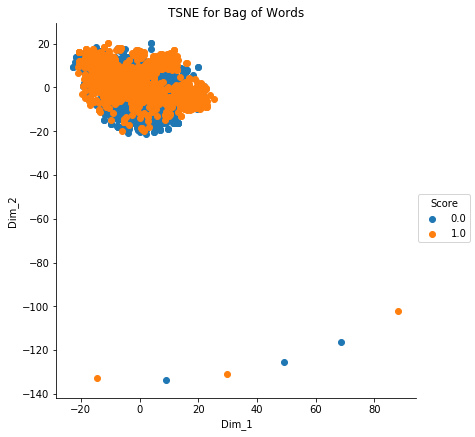

In [29]:
from sklearn.manifold import TSNE
model=TSNE(n_components = 2,random_state = 0, perplexity = 40, n_iter = 5000)
#final_counts=final_counts.todense()
final_bow_data=model.fit_transform(final_counts)
final_bow_data=np.vstack((final_bow_data.T,total_points['Score'])).T
tsne_df = pd.DataFrame(data=final_bow_data, columns=("Dim_1", "Dim_2", "Score"))


# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

## T-SNE on Bag of Words with Default Parameters

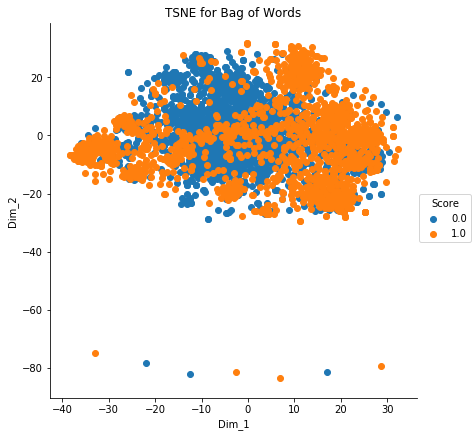

In [30]:
from sklearn.manifold import TSNE
model=TSNE(n_components = 2,random_state = 0)
#final_counts=final_counts.todense()
final_bow_data=model.fit_transform(final_counts)
final_bow_data=np.vstack((final_bow_data.T,total_points['Score'])).T
tsne_df = pd.DataFrame(data=final_bow_data, columns=("Dim_1", "Dim_2", "Score"))
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

# Tsne on TF-IDF

In [31]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(total_points['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (3000, 105115)
the number of unique words including both unigrams and bigrams  105115


### T-SNE on TF-IDF

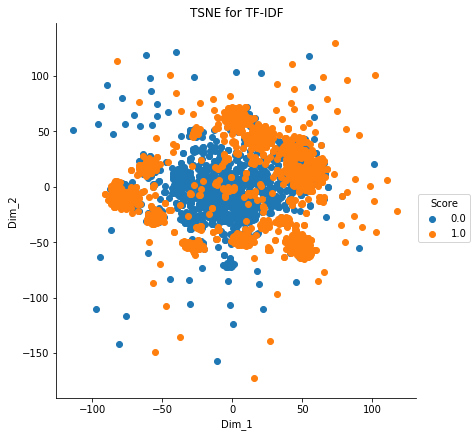

In [36]:
from sklearn.manifold import TSNE
model=TSNE(n_components = 2,random_state = 0, perplexity = 20, n_iter = 2000)
#final_tf_idf=final_tf_idf.todense()
tfidf_data=model.fit_transform(final_tf_idf)
tfidf_data=np.vstack((tfidf_data.T,total_points['Score'])).T
tsne_df = pd.DataFrame(data=tfidf_data, columns=("Dim_1", "Dim_2", "Score"))


# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE for TF-IDF")
plt.show()

### T-SNE on TF-IDF with Default Values

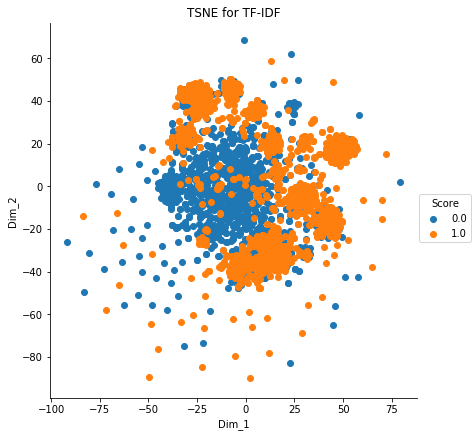

In [34]:
from sklearn.manifold import TSNE
model=TSNE(n_components = 2,random_state = 0)
#final_tf_idf=final_tf_idf.todense()
tfidf_data=model.fit_transform(final_tf_idf)
tfidf_data=np.vstack((tfidf_data.T,total_points['Score'])).T
tsne_df = pd.DataFrame(data=tfidf_data, columns=("Dim_1", "Dim_2", "Score"))


# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE for TF-IDF")
plt.show()

### Word2Vec

In [13]:
#We Are training our own Word2Vec
i=0
list_of_sent=[]
for sent in total_points['CleanedText'].values:
    list_of_sent.append(sent.split())

In [14]:
print(total_points['CleanedText'].values[0])
print("******************************************************")
print(list_of_sent[0])

witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
******************************************************
['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg']


In [15]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50,workers=4)

In [17]:
w2v_words=list(w2v_model.wv.vocab)
print("No of words occured 5 times",len(w2v_words))
print("Sample Words",w2v_words[0:50])

No of words occured 5 times 2858
Sample Words ['littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'hes', 'learn', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'still', 'abl', 'memori', 'colleg', 'grew', 'read', 'sendak', 'watch', 'realli', 'movi', 'howev', 'miss', 'hard', 'cover', 'version', 'seem', 'kind', 'flimsi', 'take', 'two', 'hand', 'keep', 'page', 'open', 'fun', 'way', 'children', 'month', 'year', 'poem']


### Average Word2Vec

In [29]:
sent_vectors=[]
for sent in tqdm(list_of_sent):
    sent_vect=np.zeros(50)
    count_vect=0
    for word in sent:
        if word in w2v_words:
            vec=w2v_model.wv[word]
            sent_vect += vec
            count_vect += 1
    if count_vect != 0:
        sent_vect /= count_vect
    sent_vectors.append(sent_vect)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 3000/3000 [00:05<00:00, 546.99it/s]

3000
50


### T-SNE on Avg Word2Vec

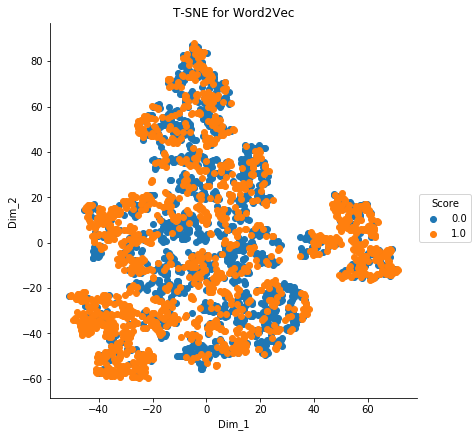

In [32]:
from sklearn.manifold import TSNE
#w2v_model=w2v_model.todense()
model=TSNE(n_components=2,random_state=0)
final_w2v=model.fit_transform(sent_vectors)
final_w2v=np.vstack((final_w2v.T,total_points['Score'])).T
tsne_df=pd.DataFrame(data=final_w2v,columns=("Dim_1","Dim_2","Score"))

#plotting the results of tsne
sn.FacetGrid(tsne_df,hue="Score",size=6).map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title("T-SNE for Word2Vec")
plt.show()

### Avg Word2Vec TF-IDF

In [34]:
model=TfidfVectorizer()
tf_idf_matrix=model.fit_transform(total_points["CleanedText"])
dictionary=dict(zip(model.get_feature_names(),list(model.idf_)))

In [39]:
tfidf_feat=model.get_feature_names()
tfidf_sent_vectors=[]
row=0
for sent in tqdm(list_of_sent):
    sent_vect=np.zeros(50)
    weight_sum=0
    for word in sent:
        if word in w2v_words:
            vec=w2v_model.wv[word]
            tf_idf=dictionary[word]*(sent.count(word)/len(sent))
            sent_vect += (vec* tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vect /= weight_sum
    tfidf_sent_vectors.append(sent_vect)
    row += 1

100%|██████████| 3000/3000 [00:06<00:00, 444.56it/s]


### T-SNE on Avg Word@vec TF-IDF

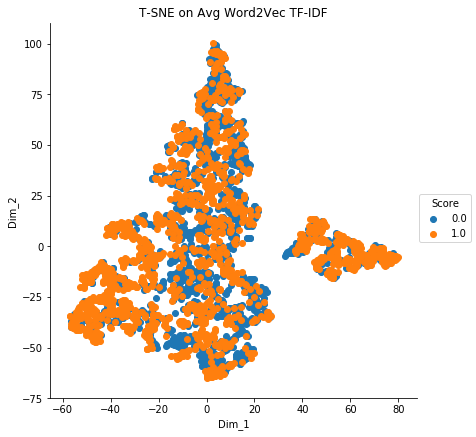

In [40]:
from sklearn.manifold import TSNE
model=TSNE(n_components=2,random_state=0)
avg_w2v_tfidf=model.fit_transform(tfidf_sent_vectors)
avg_w2v_tfidf=np.vstack((avg_w2v_tfidf.T,total_points["Score"])).T
tsne_df=pd.DataFrame(data=avg_w2v_tfidf , columns=('Dim_1','Dim_2','Score'))

#plotting the results of tsne
sn.FacetGrid(tsne_df, hue='Score' , size=6).map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title("T-SNE on Avg Word2Vec TF-IDF")
plt.show()

### Observations:
1.As we can see all the points are overlapped over each other


2.In the above plot we can not draw a line or plane to seperate the positive and negative points

### Conclusion:
This method i.e, TSNE isnot goodon this dataset